# Cloning Quasars

Let's look at the redshift distributions of the quasars in the Sloan Digital Sky Survey.

The Sloan Digital Sky Survey or SDSS is a major multi-spectral imaging and spectroscopic redshift survey using a dedicated 2.5-m wide-angle optical telescope at Apache Point Observatory in New Mexico, United States. Operations started in 1998.

In phase 1, SDSS has released photometry data 357 million (!!!) unique sources and 1.6 million spectra. In phase 2, SDSS observed the same patch of the sky many times ("time domain astronomy", and now we're going to have LSST!)

![](https://classic.sdss.org/includes/sideimages/sdss_pie2.jpg)

Download the SDSS quasara data

In [1]:
from astroML.datasets import fetch_dr7_quasar

# Fetch the quasar data
data = fetch_dr7_quasar()

# select the first 10000 points
data = data[:10000]

z = data['redshift']

- Upsample this distribution in two ways, using both rejection sampling and inverse transform.
- Check, at least visually, that the two cloned distribitions are indeed similar to the observed one (for a quantitative check, come back to this point in a few lectures)

(Hint: `scipy.stats` is your best friend)

- Think about the cosmology of quasars. How do you think they are distributed? Overplot the theorethical distribution to the measured SDSS data. Does that agree with your expectation? 

(Hint: It shouldn't. But why?) 

(Hint: `astropy.cosmology` is another close friend). The best-fit cosmological model from the Plack data is:

In [2]:
import astropy
astropy.cosmology.Planck18

FlatLambdaCDM(name="Planck18", H0=67.66 km / (Mpc s), Om0=0.30966, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.04897)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import uniform
import timeit

## Visualize the data

Text(0.5, 1.0, '$z$ Distribution')

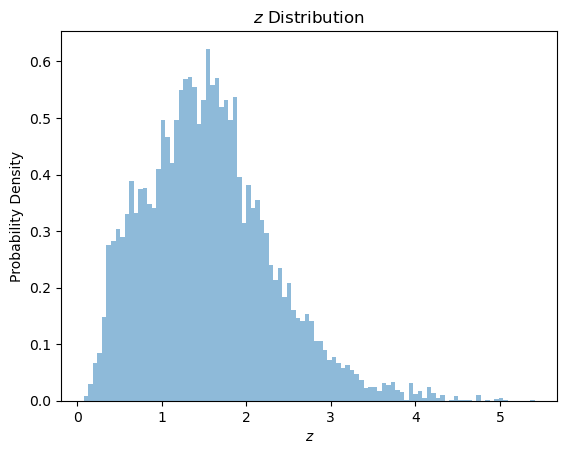

In [4]:
plt.hist(z, 100, density=True, alpha=0.5)
plt.xlabel('$z$')
plt.ylabel('Probability Density')
plt.title('$z$ Distribution')

## Functions definition

### Functions for MonteCarlo Sampling

In [6]:
# Determines the bin index of a given value 'x' in a list 
# of bin edges 'bins'
def bin_index(x, bins):
    index=0 # Initialize the indez to 0
    # Loop through the bins to find wich bin 'x' falls into
    for i in range(0, len(bins)-1): 
        if x > bins[i] and x < bins[i+1]:
            index=i
    # Return the index of the bin
    return index

# Performs rejection sampling method:
# 'z' is the data to sample from, 'N' is the number of samples to generate
def Rejection(z, N):
    # Create a hist of 'z' and normalize it
    counts, bins = np.histogram(z, 100, density=True)
    
    z_i = []
    p_i = []
    
    # Loop to generate 'N' samples using rejection sampling
    for i in range(N):
        # Draw a random value for 'z' within the range
        current_z   = uniform.rvs(0, np.max(z))
        # Determine wich bins it  falls into
        current_bin = bin_index(current_z, bins)
        # Draw a random prob. value in [0, max(counts)]
        current_p   = uniform.rvs(0, np.max(counts))
        # Keep sampling while the chosen 'p' is below the bin's prob dens
        while current_p < counts[current_bin]:
            z_i.append(current_z)
            p_i.append(current_p)
            # Draw new random values for the next iteration
            current_z   = uniform.rvs(0, np.max(z))
            current_bin = bin_index(current_z, bins)
            current_p   = uniform.rvs(0, np.max(counts))
    
    return z_i, p_i

### Functions for Inverse Transfer Sampling

In [7]:
# Computes the specific quantiles of the data 'z'
def quantile(z, N, quant):
    # Compute the percentiles for each quantile value in 'quant' and mult by 100
    percentiles = [np.percentile(z, quant_i*100) for quant_i in quant]
    
    return percentiles

# Performs Inverse transfor sampling
def inverse_transform(z, N):
    # Create a hist of 'z' and normalize it
    counts, bins = np.histogram(z, 100, density=True)
    # Generate 'N' random values unif dist between 0 and 1
    us = uniform.rvs(0, 1, N)
    # Map the uniform samples 'us' to the quantiles of 'z'
    x_i = quantile(z, N, us)
    
    return x_i

## MonteCarlo Rejection

In [8]:
z_i, p_i = Rejection(z, 30000)

In [9]:
counts, bins = np.histogram(z, 100, density=True)
np.max(counts)

0.6225033764724289

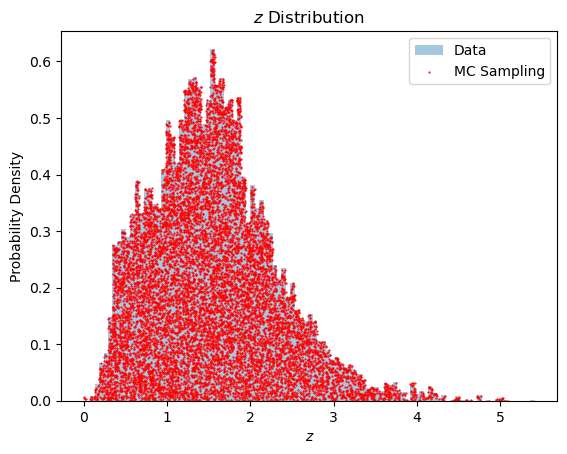

In [10]:
plt.hist(z, 100, density=True, label='Data', alpha=0.4)
plt.scatter(z_i, p_i, marker='o', s=0.3, color='red', label='MC Sampling')
plt.xlabel('$z$')
plt.ylabel('Probability Density')
plt.title('$z$ Distribution')
plt.legend()


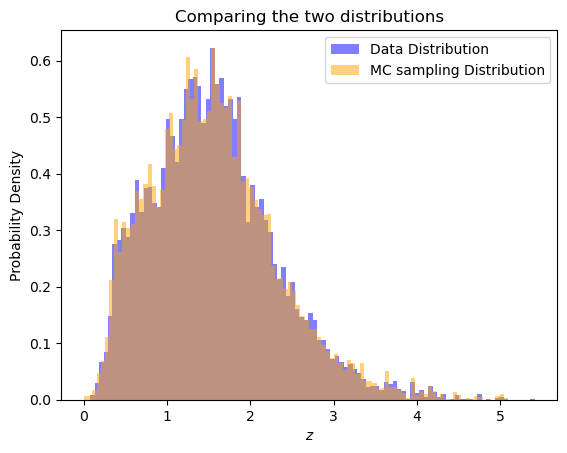

In [12]:
plt.hist(z, 100,   density=True, label='Data Distribution', color='blue', alpha=0.5)
plt.hist(z_i, 100, density=True, label='MC sampling Distribution', color='orange', alpha=0.5)
plt.xlabel('$z$')
plt.ylabel('Probability Density')
plt.title('Comparing the two distributions')
plt.legend()

## Inverse Cumulative

In [13]:
z_cloned = inverse_transform(z, 30000)

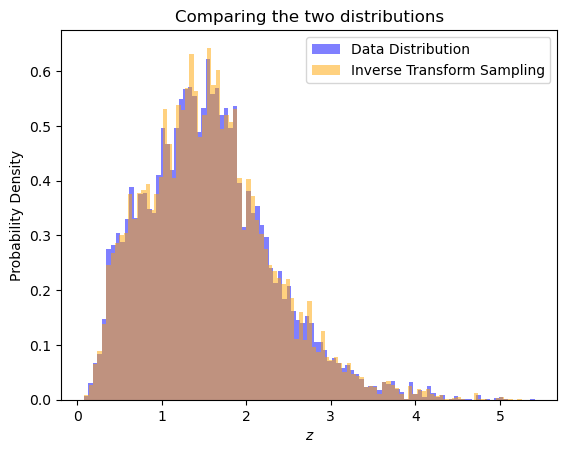

In [14]:
plt.hist(z, 100, histtype='barstacked', density=True, label='Data Distribution', color='blue', alpha=0.5)
plt.hist(z_cloned, 100,  histtype='barstacked', density=True, label='Inverse Transform Sampling', color='orange', alpha=0.5)
plt.xlabel('$z$')
plt.ylabel('Probability Density')
plt.title('Comparing the two distributions')
plt.legend()

## Theoretical Distribution

In [15]:
import astropy.cosmology

In [16]:
z_ls = np.linspace(0, 5)

pdf_ = 4*np.pi* astropy.cosmology.Planck15.differential_comoving_volume(z_ls).value
norm_pdf = pdf_/(4*np.trapz(pdf_, dx=0.01))

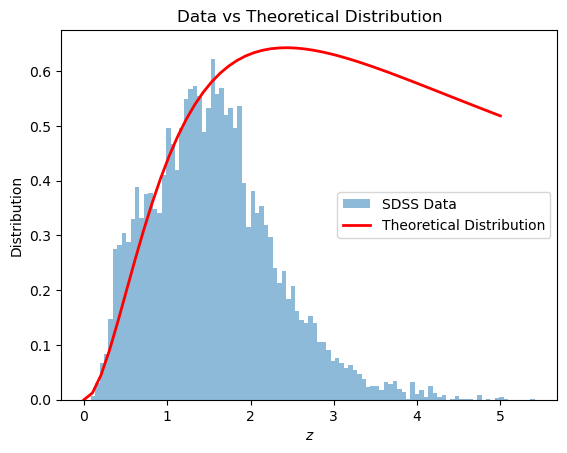

In [17]:
plt.hist(z, 100, density=True, alpha=0.5, label='SDSS Data')
plt.plot(z_ls, norm_pdf, color='red', linewidth=2, label='Theoretical Distribution')
plt.xlabel('$z$')
plt.ylabel('Distribution')
plt.title('Data vs Theoretical Distribution')
plt.legend()

The SDSS quasar redshift data match theoretical distributions well only at low redshifts due to several factors. At higher redshifts, **selection bias** occurs as quasars become harder to detect due to redshifted light. Additionally, **quasar evolution** means their population density peaks at intermediate redshifts, then declines. **Absorption effects** from intergalactic gas further obscure high-redshift quasars. Finally, **theoretical models** may not fully account for cosmological evolution at higher redshifts, leading to discrepancies.